In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from IPython.core.pylabtools import figsize

Load Dataset and Read Dataset

In [5]:
df = pd.read_csv('Telco-Customer-Churn.csv')
print(df.shape)

(7043, 21)


In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
#check whether there are null data
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [9]:
#convert data type of feature 'TotalCharges' to float
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].mean())

In [10]:
#delete irrelevant features from data
df.drop(columns=["customerID"], inplace=True)

In [11]:
#check class distribution of some features
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [12]:
df['Contract'].value_counts()

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [13]:
df['MonthlyCharges'].value_counts()

MonthlyCharges
20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
23.65      1
114.70     1
43.65      1
87.80      1
78.70      1
Name: count, Length: 1585, dtype: int64

In [14]:
df["Churn"].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [15]:
#identify class distribution of target column
print(df["Churn"].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


Exploratory Data Analysis (EDA)

In [16]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1400.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.000,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.000,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.35,89.85,118.75
TotalCharges,7043.0,2283.300441,2265.000258,18.80,402.225,1400.55,3786.60,8684.80


In [18]:
# create histogram for numerical features
def make_histogram(df, column):

  plt.figure(figsize(5, 3))
  sns.histplot(df[column], kde=True)
  plt.title(f"Distribution of {column}")

  col_mean = df[column].mean()
  col_median = df[column].median()

  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend()

  plt.show()

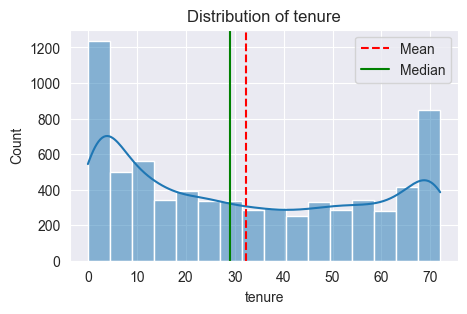

In [19]:
make_histogram(df, "tenure")

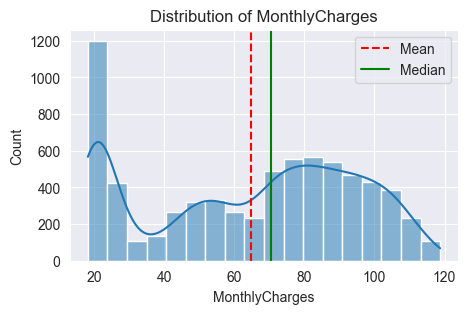

In [20]:
make_histogram(df, "MonthlyCharges")

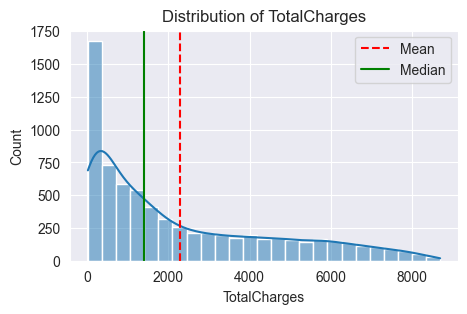

In [21]:
make_histogram(df, "TotalCharges")

In [22]:
# create box plots for numerical features

In [23]:
def make_boxplot(df, column):
  plt.figure(figsize=(5, 3))
  sns.boxplot(y=df[column])
  plt.title(f"Box Plot of {column}")
  plt.ylabel(column)
  plt.show

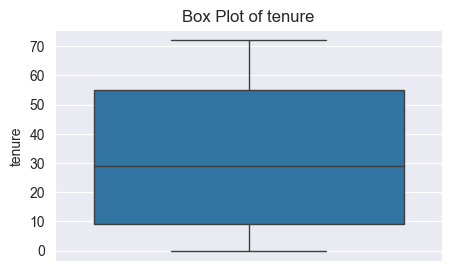

In [24]:
make_boxplot(df, "tenure")

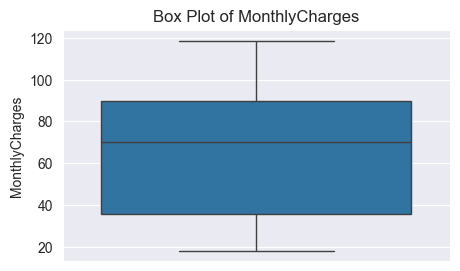

In [25]:
make_boxplot(df, "MonthlyCharges")

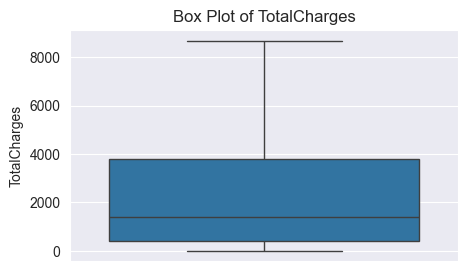

In [26]:
make_boxplot(df, "TotalCharges")

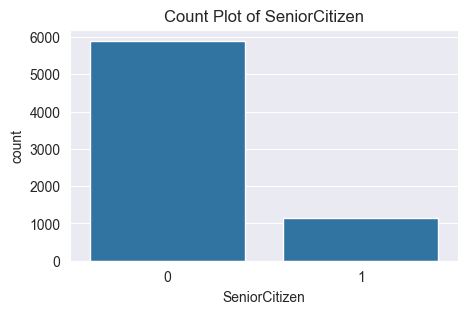

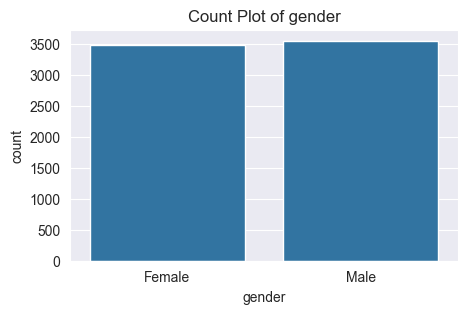

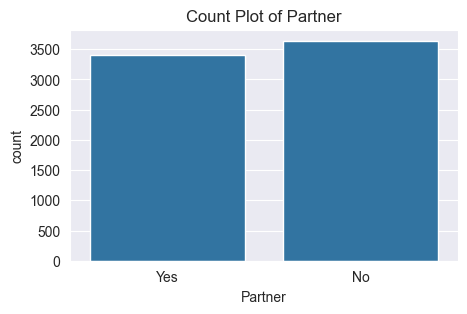

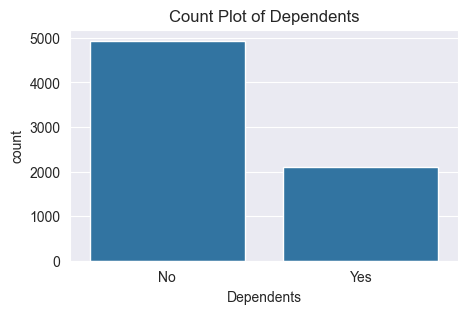

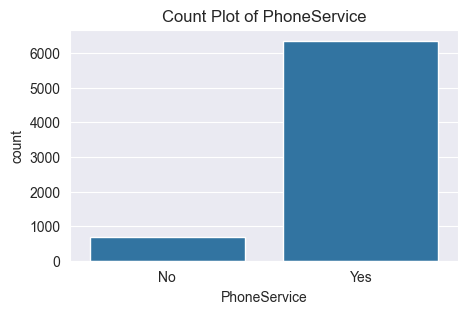

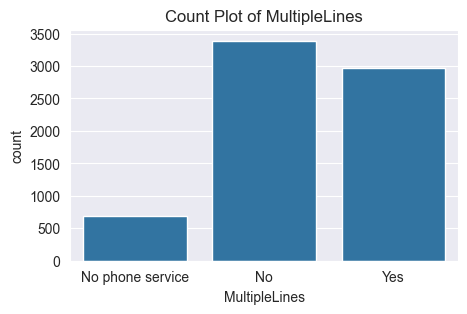

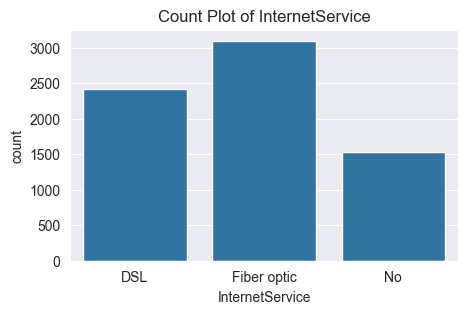

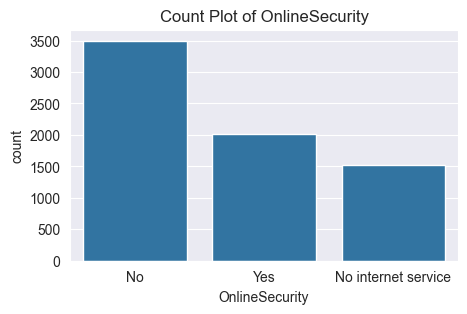

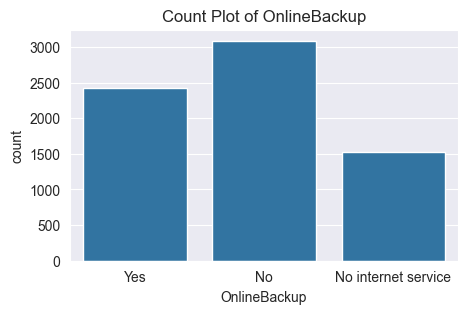

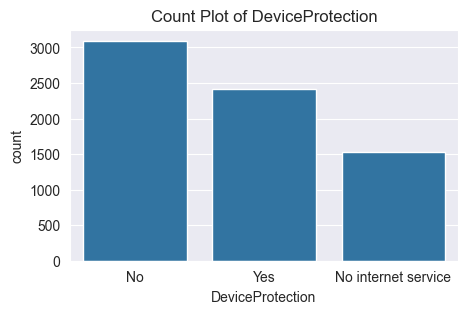

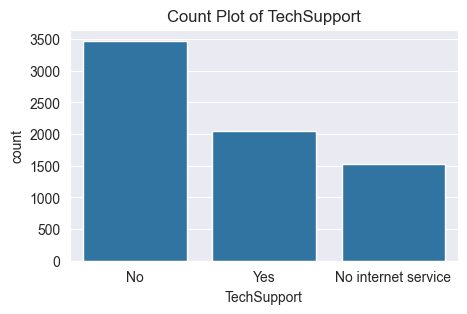

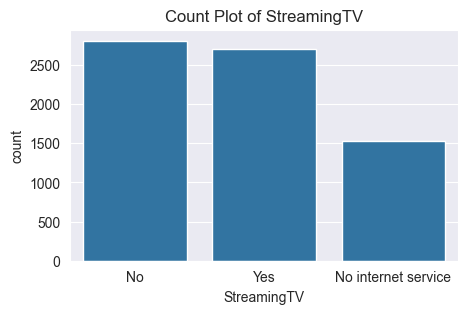

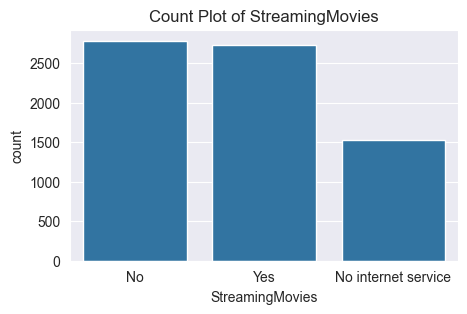

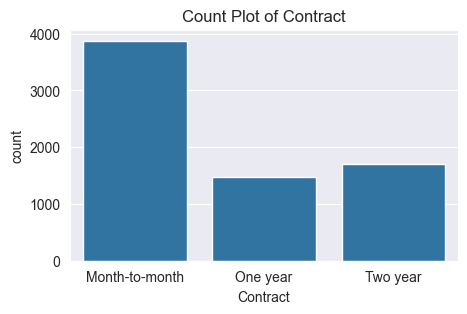

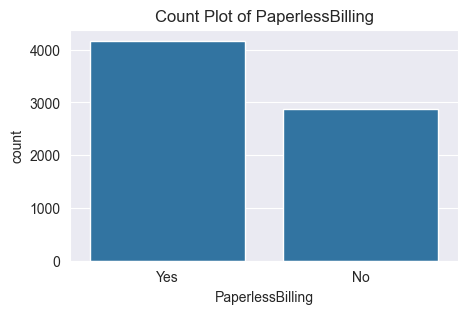

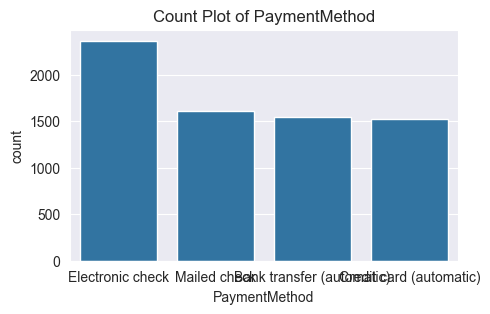

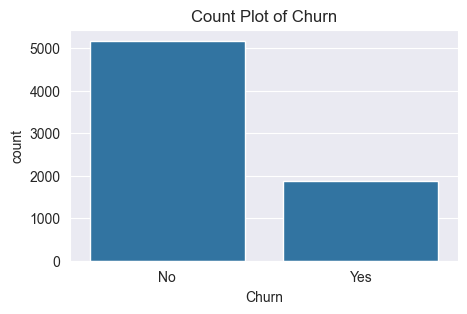

In [27]:
#creat count plot for categorical features
object_columns = df.select_dtypes(include="object").columns.to_list()

object_columns = ["SeniorCitizen"] + object_columns

for column in object_columns:
  plt.figure(figsize=(5, 3))
  sns.countplot(x=df[column])
  plt.title(f"Count Plot of {column}")
  plt.show()

Data Preprocessing: Label Encoding

In [28]:
#label encoding of target column 'churn'
df["Churn"] = df["Churn"].replace({"Yes":1, "No":0})
print(df["Churn"].value_counts())

Churn
0    5174
1    1869
Name: count, dtype: int64


In [29]:
#label encoding of categorical features
object_columns = df.select_dtypes(include="object").columns
print(object_columns)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [30]:
for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


Split Traning and Test Data and Handle Class Imbalance

In [31]:
X = df.drop(columns=["Churn"])
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [32]:
smote = SMOTE(random_state=30)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Model Training

In [33]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=33),
    "Random Forest": RandomForestClassifier(random_state=33),
    "XGBoost": XGBClassifier(random_state=33)
}

In [34]:
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name, model in models.items():
  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} cross-validation accuracy: {np.mean(scores)}")
  print("------")

  cv_scores

Decision Tree cross-validation accuracy: 0.7893716700810482
------
Random Forest cross-validation accuracy: 0.8419729265256185
------
XGBoost cross-validation accuracy: 0.8304720457228145
------


In [35]:
#train random forest model as it has the highest accuracy
randomForest = RandomForestClassifier(random_state=33)
randomForest.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=33)

Model Evaluation

In [36]:
y_test_predict = randomForest.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_test_predict))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_predict))
print("Classification Report:\n", classification_report(y_test, y_test_predict))

Accuracy Score: 0.7721788502484032
Confusion Matrix:
 [[855 146]
 [175 233]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1001
           1       0.61      0.57      0.59       408

    accuracy                           0.77      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.77      0.77      0.77      1409

